In [3]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

The Mexican dataset composed of SET images needs a metadata with the bounding boxes.<br>
There are 6 ROI annotations, 2 per radiologist. We will select the radiologist that better knows the dataset as the ground truth.

In [4]:
import numpy as np
import pandas as pd
import SimpleITK as sitk
from matplotlib import pyplot as plt
import cv2 as cv
from scipy import stats
from tqdm import tqdm

In [6]:
im_dir = repo_path / 'data/SET-Mex/images/substracted'
masks_dir = repo_path / 'data/SET-Mex/binary_masks/L_1_seg' #<---- using radiologist V
pat_id_list = list(masks_dir.glob('*.nrrd'))
pat_id_list = [int(ex_mask_path.name.split('_')[0]) for ex_mask_path in pat_id_list]
pat_id_list.sort()

# saving paths
save_dir = repo_path / 'data/SET-Mex/images/substracted_jpg'

# Create metadata and cropped images

In [8]:
def prepare_array(array:np.array, min_val:int, max_val:int):
    """This function correctes the array, maps the array to the range 0-255, and clips values below min_val and above max_val

    Args:
        array (np.array): image array
        min_val (int): min value to clip
        max_val (int): max value to clip

    Returns:
        np.array: image array clipped and mapped to 0-255
    """
    
    # SET correction
    array = array.astype(np.int32)
    array = (array - np.power(2,15)).astype(np.int16)

    # send to min value all piel below that value
    array[array<min_val] = min_val
    # same for max value
    array[array>max_val] = max_val
    # map im_array to 256 pixels
    array = (array - np.min(array)) / (np.max(array) - np.min(array))
    array = (array * 255).astype(np.uint8)
    
    return array

def get_normal_BBox (im_array:np.array):
    """Given an mammogram image, returns the bounding box of the breast

    Args:
        im_array (np.array): array of the mammogram image, with background black

    Returns:
        tuple, array: bounding box coordinates (x1, y1, x2, y2), binary mask of the breast
    """
    #threshold im_array 
    img = cv.threshold(im_array, 0, 255, cv.THRESH_BINARY)[1]  # ensure binary
    nb_components, output, stats, _ = cv.connectedComponentsWithStats(img, connectivity=4)
    sizes = stats[:, -1]
    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]
    img2 = np.zeros(output.shape,dtype=np.uint8)
    img2[output == max_label] = 255
    contours, _ = cv.findContours(img2,cv.RETR_TREE,cv.CHAIN_APPROX_NONE)

    cnt = contours[0]

    x,y,w,h = cv.boundingRect(cnt)
    
    return (x,y,x+w,y+h), img2

def get_breastbox_cedm(SET_array:np.array, pat_num:str):
    """Given an SET image, returns the bounding box of the breast

    Args:
        SET_array (np.array): SET array in original format
        pat_num (int or str): patient number

    Returns:
        tuple: bounding box coordinates (x1, y1, x2, y2)
    """
    SET_mode = stats.mode(SET_array[SET_array!=0].flatten(), keepdims=True)[0][0]
    # send pixels to 0 in the mode
    SET_array_blackbg = SET_array.copy()
    SET_array_blackbg[SET_array_blackbg==SET_mode] = 0
    # also remove +-range the mode in one line
    elimination_range = 11 if str(pat_num) in ['8', '38'] else 7
    for i in range(elimination_range): # 7 is the standard value, for special cases 11 or 15 may work. Check final bbox
        SET_array_blackbg[(SET_array_blackbg==SET_mode+i) | (SET_array_blackbg==SET_mode-i)] = 0

    bbox, _ = get_normal_BBox(SET_array_blackbg)

    return bbox

def SET_metadata_and_image(pat_id:int, im_dir:Path, masks_dir:Path):
    """Given a patient id, returns the cropped image and metadata

    Args:
        pat_id (int): patient id
        im_dir (Path): the image directory
        masks_dir (Path): the masks directory

    Returns:
        np.array, pd.DataFrame: cropped image, metadata with the following columns: patient_id, image_name, region_id, bbox, lesions_per_patient
    """
    
    # read nrrd mask
    mask_path = masks_dir / f'{pat_id}_G_L.seg.nrrd'
    mask_np = sitk.GetArrayFromImage(sitk.ReadImage(str(mask_path)))

    # reading array
    im_path = im_dir / f'Pat_{pat_id}_SET_SMC_to_CMC_1min.tif'
    im_array = sitk.GetArrayFromImage(sitk.ReadImage(str(im_path)))
    below_cut = -150
    above_cut = 300
    im_array = prepare_array(im_array, below_cut, above_cut)
    # get breast bounding box
    breast_box = get_breastbox_cedm(im_array, pat_id)

    # use breast_box to crop image and mask
    cropped_im = im_array[breast_box[1]:breast_box[3], breast_box[0]:breast_box[2]]
    cropped_mask = mask_np[breast_box[1]:breast_box[3], breast_box[0]:breast_box[2]]

    # get bbox of lesion
    lesion_bbox, _ = get_normal_BBox(cropped_mask)
    # redefine bboz to be x, y, w, h
    lesion_bbox = (lesion_bbox[0], lesion_bbox[1], lesion_bbox[2]-lesion_bbox[0], lesion_bbox[3]-lesion_bbox[1])

    # add to metadata
    metadata = pd.DataFrame({
        'patient_id': pat_id,
        'image_name': im_path.stem,
        'region_id': 0,
        'bbox': str(lesion_bbox),
        'lesions_per_patient': 1,
    }, index=[0])

    # return cropped image and metadata
    return cropped_im, metadata

In [9]:
metadata_general = None

for pat_id in tqdm(pat_id_list):

    cropped_im, metadata = SET_metadata_and_image(pat_id, im_dir, masks_dir)
    # save cropped image
    cv.imwrite(str(save_dir / f'{metadata["image_name"].values[0]}.png'), cropped_im)
    # save metadata
    metadata_general = pd.concat([metadata_general, metadata], axis=0)
metadata_general.to_csv(repo_path / 'data/SET-Mex/metadata' / 'SET_png_metadata.csv', index=False)

100%|██████████| 33/33 [00:55<00:00,  1.69s/it]


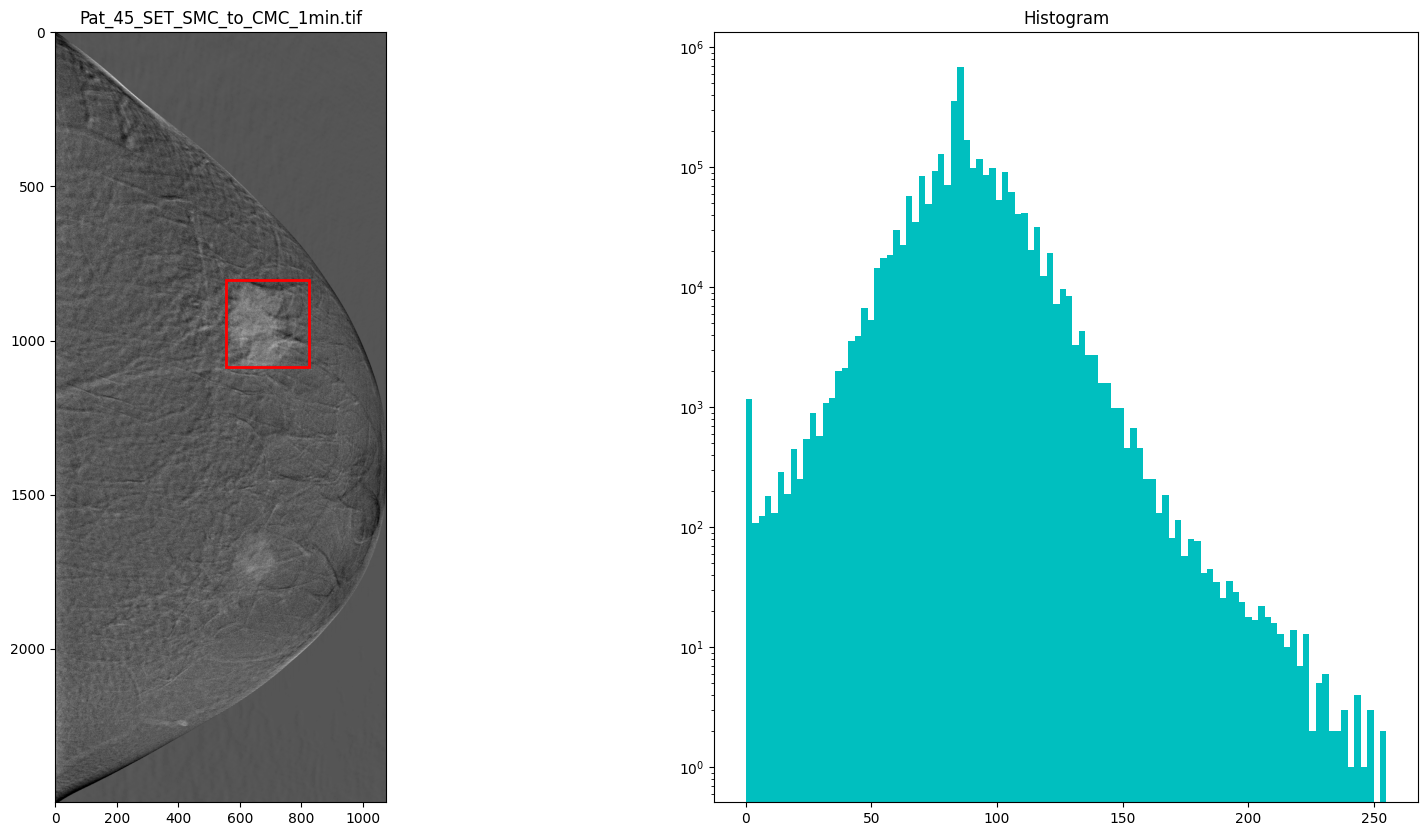

In [129]:
im_num = 32
cropped_im = cv.imread(str(save_dir / f'{metadata_general.image_name.iloc[im_num]}.png'), cv.IMREAD_GRAYSCALE)
lesion_bbox = eval(metadata_general.bbox.iloc[im_num])
im_name = metadata_general.image_name.iloc[im_num]

# show histogram of image
fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].imshow(cropped_im, cmap='gray')
axs[0].set_title(f'{im_name}')
axs[0].add_patch(plt.Rectangle((lesion_bbox[0], lesion_bbox[1]), lesion_bbox[2], lesion_bbox[3], fill=None, edgecolor='r', lw=2))
axs[1].hist(cropped_im.flatten(), bins=100, color='c', log=True)
axs[1].set_title('Histogram')
plt.show()